In [1]:
import pandas as pd
import new_lib as nl
import wrangle as w
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import functions as f

## Gather and wrangle data using wrangle.py

In [2]:
city = w.wrangle_temp()
city
## Wragle the data for the city of London

,AverageTemperature
dt,
1960-01-01,38.7608
1960-02-01,39.5528
1960-03-01,43.1942
1960-04-01,47.8274
1960-05-01,55.5962
...,...
2013-04-01,45.5540
2013-05-01,51.4562
2013-06-01,58.4564


## Creating train val test splits
## Decided to use only data since 1960 to better capture recent trends

In [3]:
train_size = int(round(city.shape[0] * 0.5))
train_size
# Creating train size

322

In [4]:
val_size = int(round(city.shape[0] * 0.3))
val_size
val_index = train_size + val_size
val_index
val_size
# creating val size and index point

193

In [5]:
test_size = int(round(city.shape[0] * .2))
test_size
# creating test size

129

In [6]:
train_size + val_size + test_size == len(city)
# checking the length of the splits

True

In [7]:
train = city[:train_size]
val = city[train_size:val_index]
test = city[val_index:]
# creating the splits

In [8]:
train
# checking results

,AverageTemperature
dt,
1960-01-01,38.7608
1960-02-01,39.5528
1960-03-01,43.1942
1960-04-01,47.8274
1960-05-01,55.5962
...,...
1986-06-01,59.3258
1986-07-01,62.4776
1986-08-01,58.1360


## Checking Data for any observations

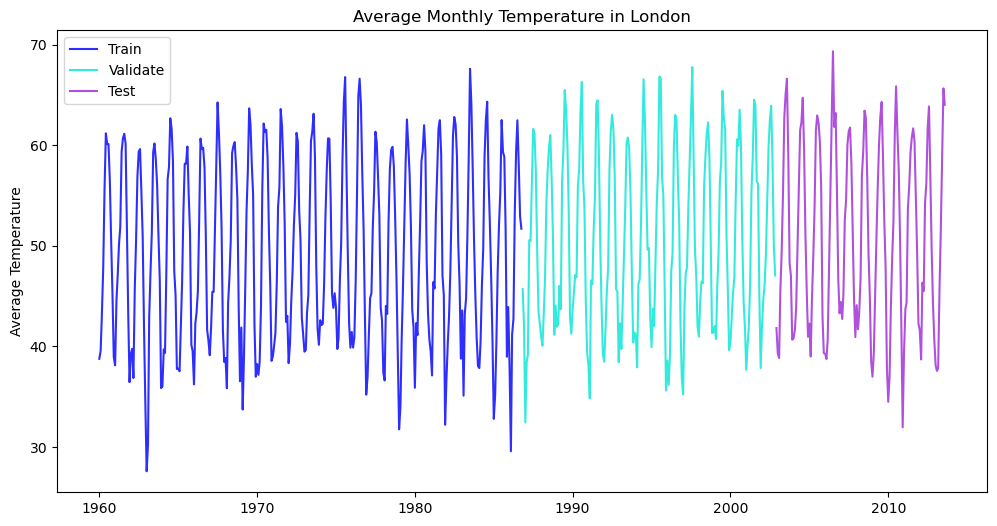

In [9]:
plt.figure(figsize=(12,6))
plt.plot(train, color='#2E2EFE', label = 'Train')
plt.plot(val, color='#33EBDC', label = 'Validate')
plt.plot(test, color='#B051DE', label = 'Test')
plt.legend()
plt.ylabel('Average Temperature')
plt.title('Average Monthly Temperature in London')
plt.show()
## Plotting the data to observe any noticeable trends in Temperature

## Observed very consistent trends with few outliers. Temperature ranges generally about 35 degrees throughout the year

In [11]:
avg_temp = city.AverageTemperature.mean()
avg_temp
# Getting a simple average to create a baseline

49.91297391304349

In [12]:
preds = pd.DataFrame({'AverageTemperature': [avg_temp]}, index = val.index)
# assigning predictions

## Creating a baseline RMSE to compare models against

AverageTemperature -- RMSE: 9


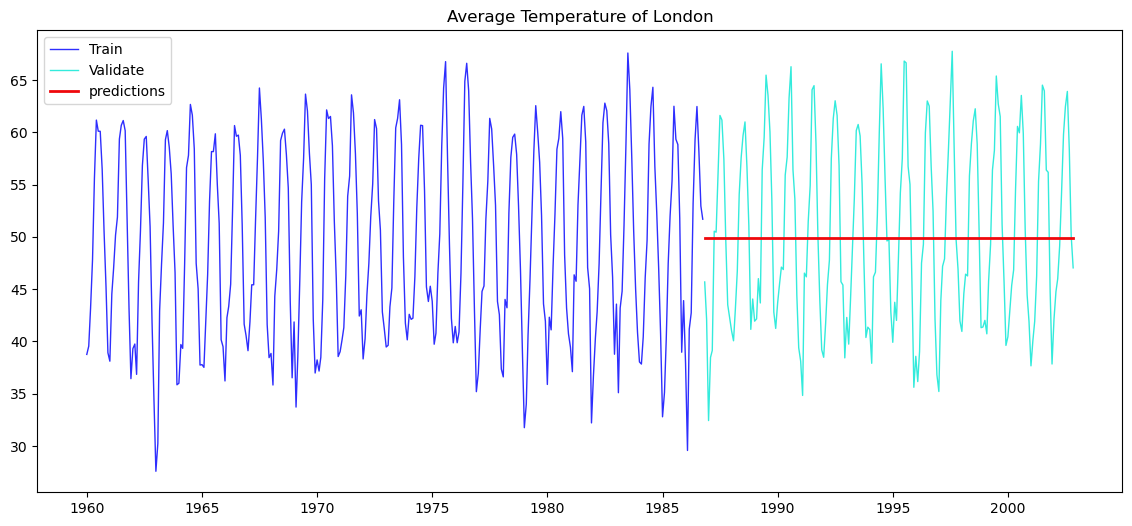

In [13]:
f.plot_and_eval('AverageTemperature', preds)
# Plotting baseline

## Testing other potential baselines

In [15]:
periods = [4, 6, 12, 24]

for p in periods: 
    rolling_temp = round(train['AverageTemperature'].rolling(p).mean()[-1], 2)
    preds = f.make_baseline_predictions(rolling_temp)
    e = evaluate('AverageTemperature')
    print(f'{e} is the RMSE for {p} periods')
# for loop to test 4 different periods to see if they can create a better baseline

11.0 is the RMSE for 4 periods
10.0 is the RMSE for 6 periods
9.0 is the RMSE for 12 periods
9.0 is the RMSE for 24 periods


## Holt Winters Model that shows clear seasonal trend

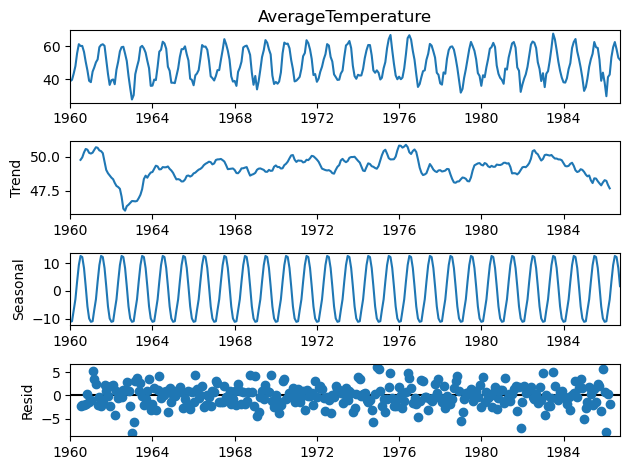

In [16]:
sm.tsa.seasonal_decompose(train['AverageTemperature']).plot() 
None
# Holt-Winters model to see if there is seasonality and trends

In [17]:
holt1 = Holt(train, exponential = False, damped = True)
holt1 = holt1.fit(optimized = True)
preds = pd.DataFrame({'AverageTemperature': holt1.predict(start = val.index[0], end = val.index[-1])})
preds
# Creating a Holts prediction

,AverageTemperature
1986-11-01,49.649386
1986-12-01,48.239950
1987-01-01,47.112402
1987-02-01,46.210363
1987-03-01,45.488731
...,...
2002-07-01,42.602206
2002-08-01,42.602206
2002-09-01,42.602206
2002-10-01,42.602206


## Created a Holts model that was worse than baseline

AverageTemperature -- RMSE: 12


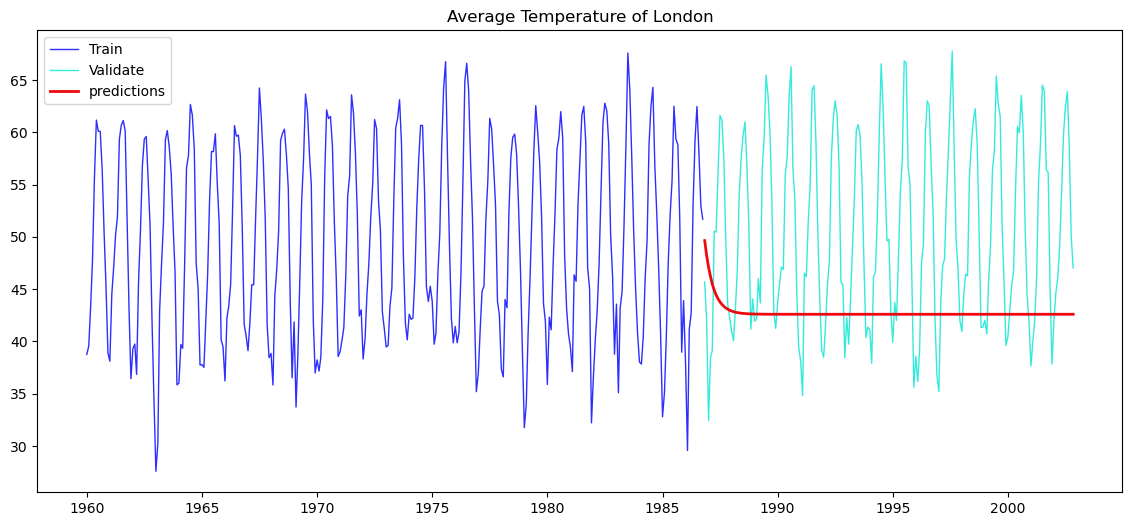

In [19]:
f.plot_and_eval('AverageTemperature', preds)
# Plotting the prediction

In [20]:
season_fit1 = ExponentialSmoothing(train.AverageTemperature, seasonal_periods=12, trend='add', seasonal='add').fit()
season_fit2 = ExponentialSmoothing(train.AverageTemperature, seasonal_periods=12, trend='add', seasonal='mul').fit()
season_fit3 = ExponentialSmoothing(train.AverageTemperature, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit()
season_fit4 = ExponentialSmoothing(train.AverageTemperature, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit()
# creating multiple seasonal predictions with a variety of tweaks to hyperparameters

## Created and tested 4 different models using seasonal model with different hyperparameters

In [21]:
results_temp=pd.DataFrame({'model':['season_fit1', 'season_fit2', 'season_fit3', 'season_fit4'],
                              'RMSE':[sqrt(season_fit1.sse/len(train)), sqrt(season_fit2.sse/len(train)), sqrt(season_fit3.sse/len(train)), sqrt(season_fit4.sse/len(train))]})
results_temp.sort_values(by = 'RMSE')
# RMSE results of all prediciton models sorted by values lowest to highest

,model,RMSE
2,season_fit3,2.381815
3,season_fit4,2.383028
1,season_fit2,2.389978
0,season_fit1,2.390436


In [22]:
preds = pd.DataFrame({'AverageTemperature': season_fit3.forecast(val.shape[0])},
                          index=val.index)
preds
# Creating a dataframe of predicitons to use for modeling

,AverageTemperature
dt,
1986-11-01,43.540721
1986-12-01,39.199229
1987-01-01,37.952908
1987-02-01,38.193577
1987-03-01,42.115084
...,...
2002-07-01,61.811898
2002-08-01,61.268693
2002-09-01,57.222982


## Checked best performing model and found a significantly better RMSE

AverageTemperature -- RMSE: 3


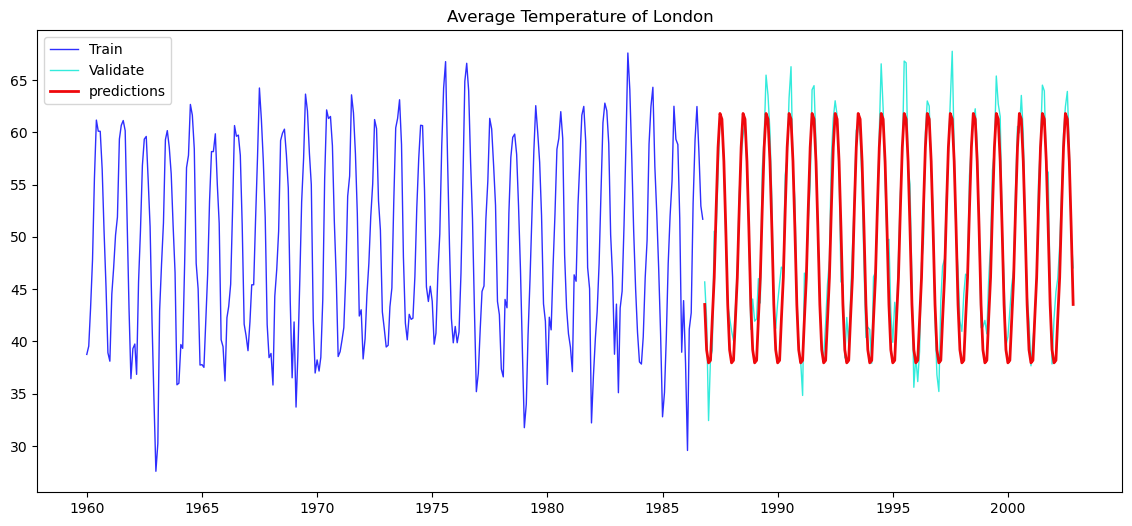

In [24]:
f.plot_and_eval('AverageTemperature', preds)
# modeling the best model

In [25]:
preds = pd.DataFrame({'AverageTemperature': season_fit3.forecast(val.shape[0] + test.shape[0] + 120)})
preds
# Create predicitons for 10 years into the future

,AverageTemperature
1986-11-01,43.540721
1986-12-01,39.199229
1987-01-01,37.952908
1987-02-01,38.193577
1987-03-01,42.115084
...,...
2023-04-01,46.111279
2023-05-01,52.595980
2023-06-01,58.570683
2023-07-01,61.811898


## Predicitions for temperature 10 years out from end of data. Data looks consistent with trends
## Maybe a slight dip down

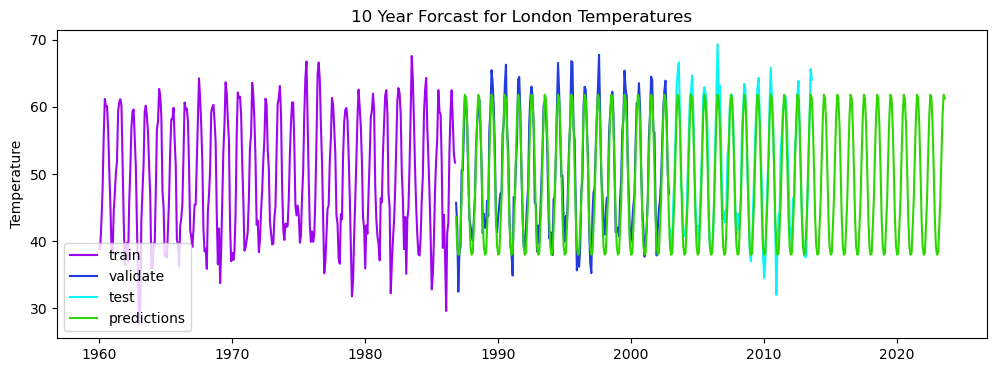

In [26]:
f.final_plot('AverageTemperature', preds)
# Plot the final model predicitions